In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

# Setting random seed to obtain reproducible results.
import tensorflow as tf

tf.random.set_seed(42)

import keras
from keras import layers

import os
import glob
import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES = 32
POS_ENCODE_DIMS = 16
EPOCHS = 20

12727482/12727482 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


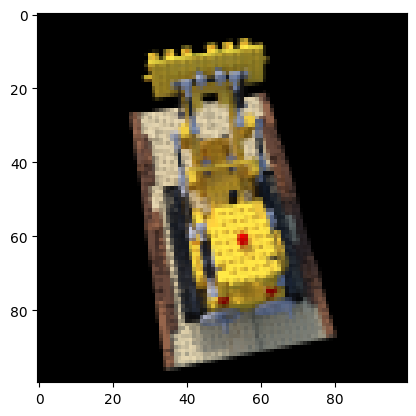

In [2]:
url = (
    "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"
)
data = keras.utils.get_file(origin=url)

data = np.load(data)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

# Plot a random image from the dataset for visualization.
plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

In [3]:
def encode_position(x):
    """Encodes the position into its corresponding Fourier feature.

    Args:
        x: The input coordinate.

    Returns:
        Fourier features tensors of the position.
    """
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0**i * x))
    return tf.concat(positions, axis=-1)

In [4]:
def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera.

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Build a meshgrid for the rays.
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )

    # Normalize the x axis coordinates.
    transformed_i = (i - width * 0.5) / focal

    # Normalize the y axis coordinates.
    transformed_j = (j - height * 0.5) / focal

    # Create the direction unit vectors.
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # Get the camera matrix.
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # Get origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Return the origins and directions.
    return (ray_origins, ray_directions)

In [5]:
def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """Renders the rays and flattens it.

    Args:
        ray_origins: The origin points for rays.
        ray_directions: The direction unit vectors for the rays.
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    # Compute 3D query points.
    # Equation: r(t) = o+td -> Building the "t" here.
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        # Inject uniform noise into sample space to make the sampling
        # continuous.
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise

    # Equation: r(t) = o + td -> Building the "r" here.
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    return (rays_flat, t_vals)

In [6]:

def map_fn(pose):
    """Maps individual pose to flattened rays and sample points.

    Args:
        pose: The pose matrix of the camera.

    Returns:
        Tuple of flattened rays and sample points corresponding to the
        camera pose.
    """
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (rays_flat, t_vals)

In [7]:
# Create the training split.
split_index = int(num_images * 0.8)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

In [8]:
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [9]:
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [10]:
def get_nerf_model(num_layers, num_pos):
    """Generates the NeRF neural network.

    Args:
        num_layers: The number of MLP layers.
        num_pos: The number of dimensions of positional encoding.

    Returns:
        The `keras` model.
    """
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=64, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            # Inject residual connection.
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

In [11]:
def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    """Generates the RGB image and depth map from model prediction.

    Args:
        model: The MLP model that is trained to predict the rgb and
            volume density of the volumetric scene.
        rays_flat: The flattened rays that serve as the input to
            the NeRF model.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Get the predictions from the nerf model and reshape it.
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    # Slice the predictions into rgb and sigma.
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # Get the distance of adjacent intervals.
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Get transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)

In [12]:
class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            # Get the predictions from the model.
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        # Get the trainable variables.
        trainable_variables = self.nerf_model.trainable_variables

        # Get the gradeints of the trainiable variables with respect to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Apply the grads and optimize the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # Get the predictions from the model.
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]

In [13]:
test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []

In [14]:
class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plot the rgb, depth and the loss plot.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.utils.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(keras.utils.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()

In [15]:
num_pos = H * W * NUM_SAMPLES
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

In [16]:
model = NeRF(nerf_model)
model.compile(
    optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError()
)

In [17]:
if not os.path.exists("images"):
    os.makedirs("images")

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


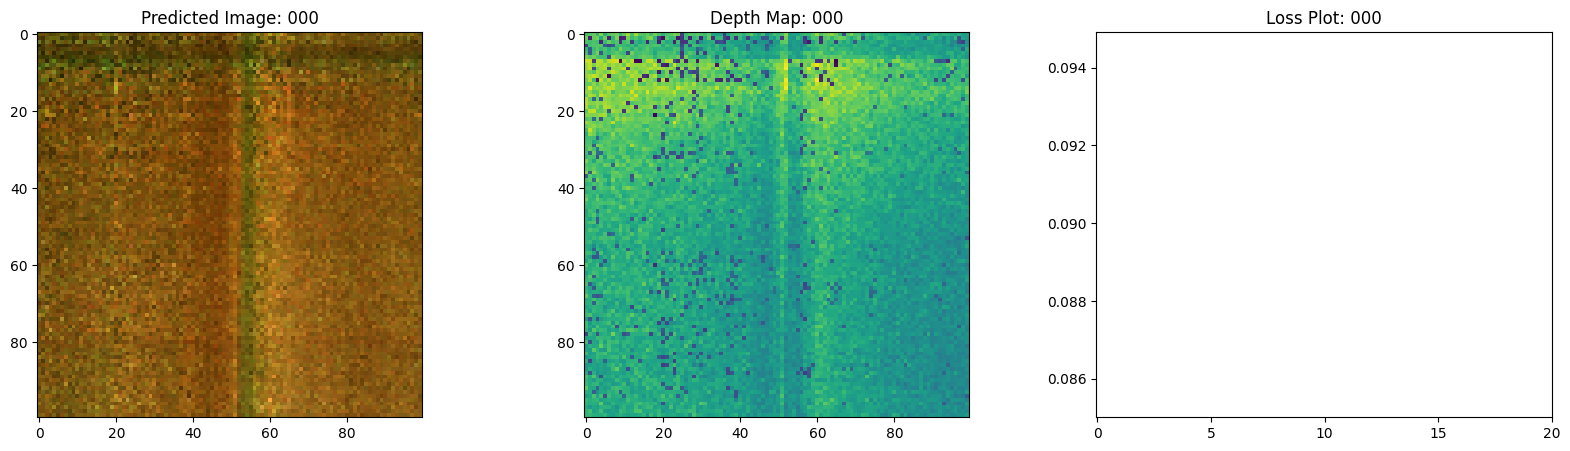

16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.1071 - psnr: 9.8760 - val_loss: 0.0816 - val_psnr: 11.2492
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


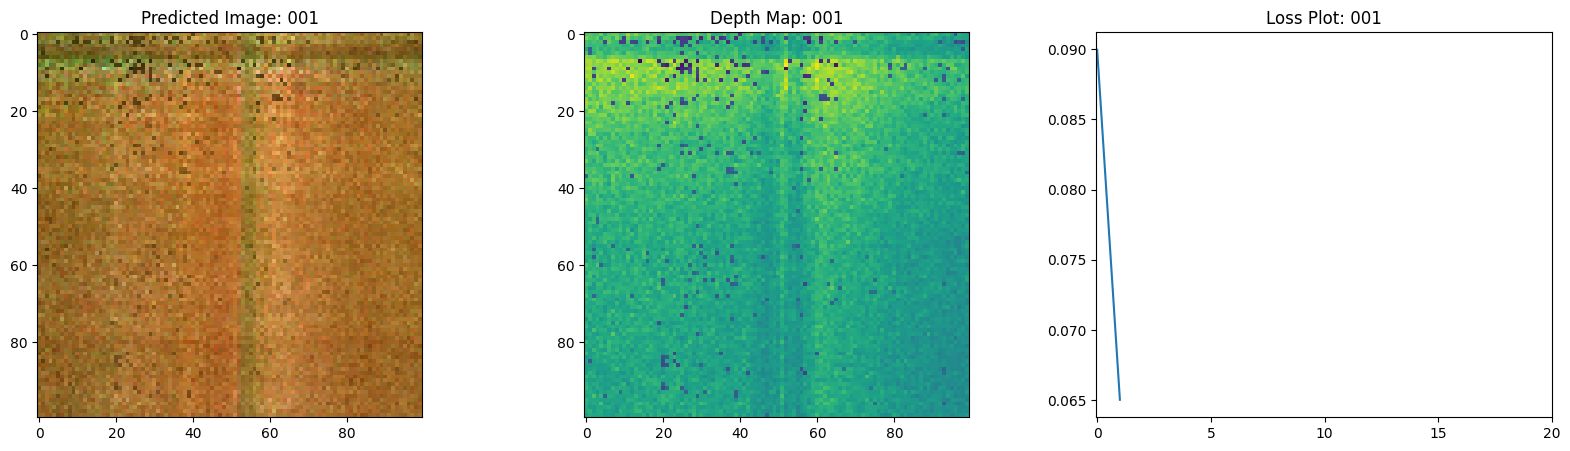

16/16 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - loss: 0.0647 - psnr: 12.3802 - val_loss: 0.0660 - val_psnr: 12.1122
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


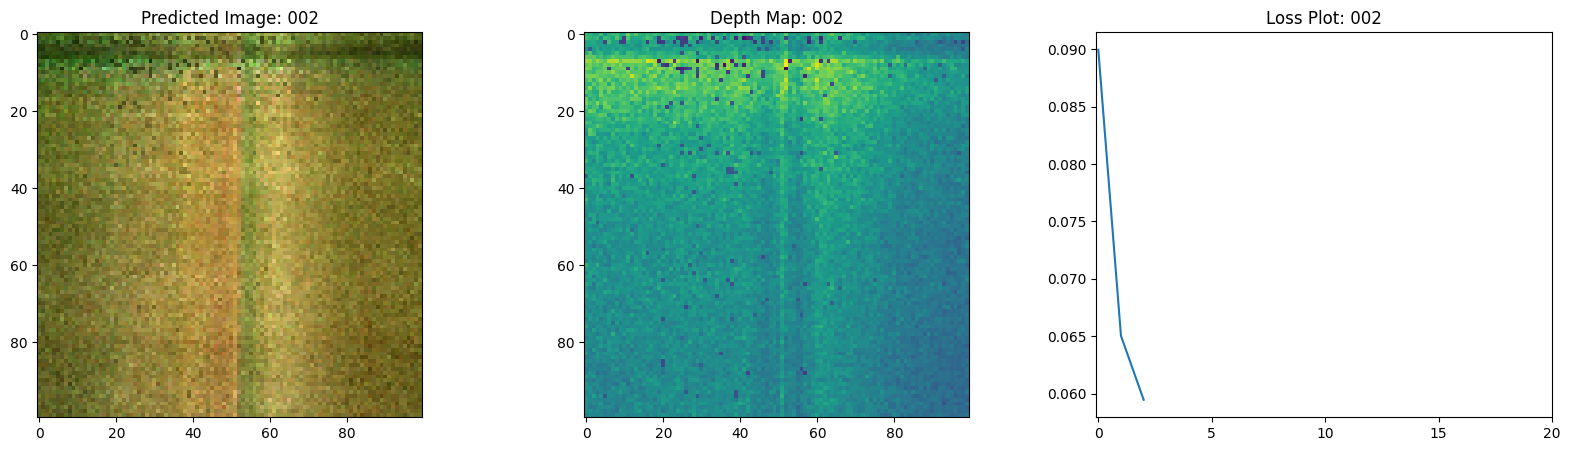

16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 0.0594 - psnr: 12.5651 - val_loss: 0.0642 - val_psnr: 12.3304
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


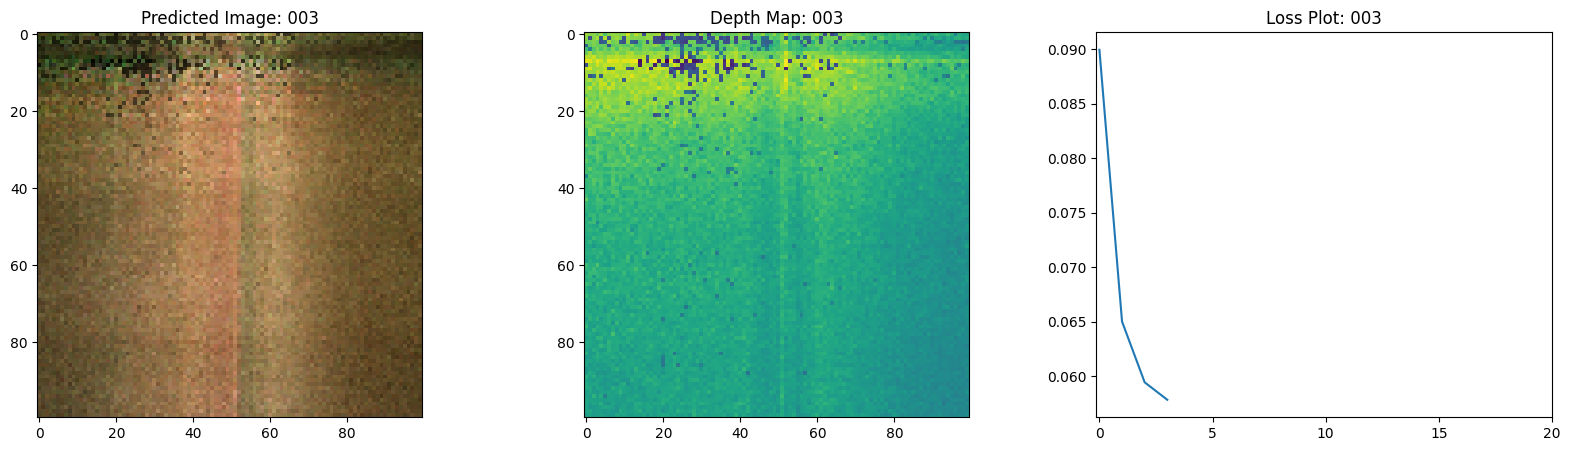

16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0573 - psnr: 12.8345 - val_loss: 0.0607 - val_psnr: 12.5438
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


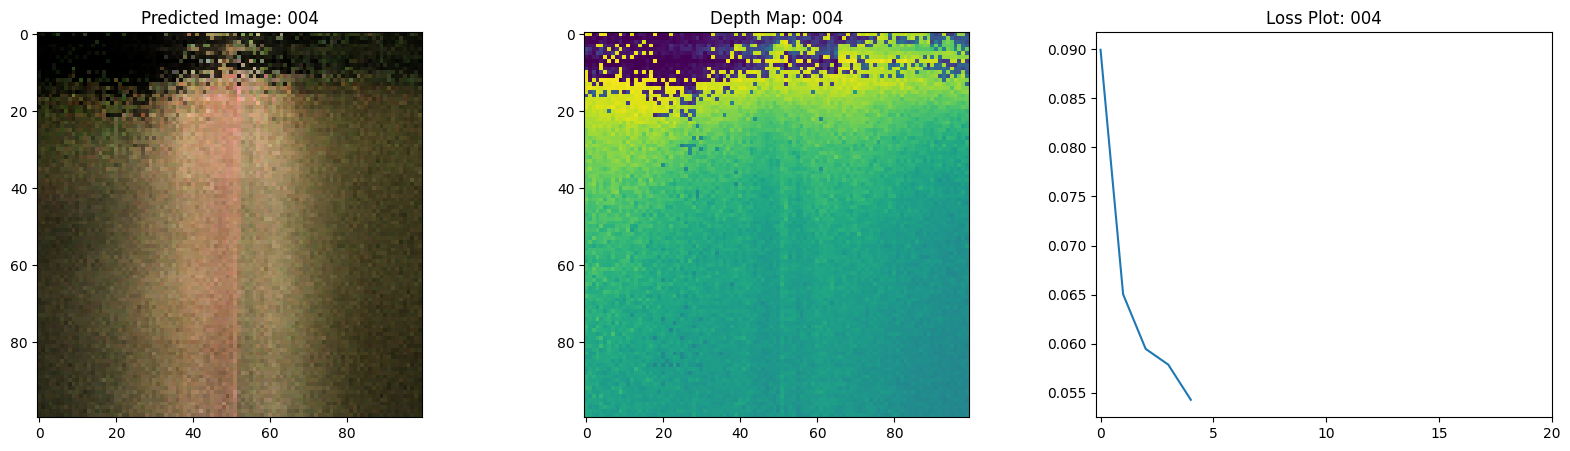

16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0537 - psnr: 13.1006 - val_loss: 0.0547 - val_psnr: 13.0200
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


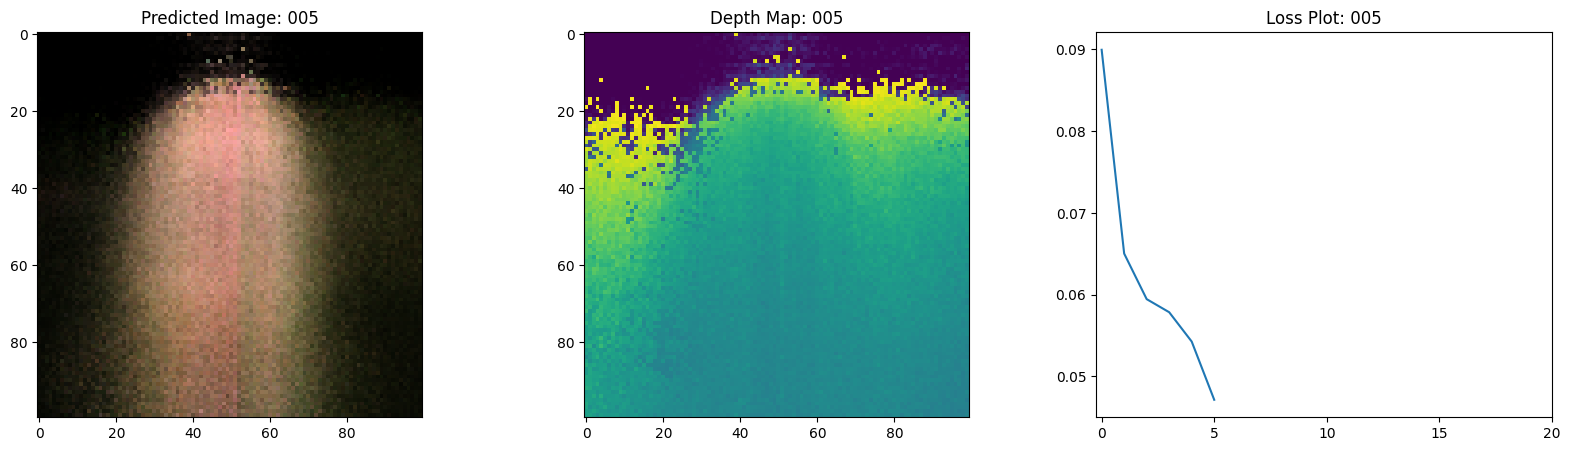

16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0489 - psnr: 13.5325 - val_loss: 0.0454 - val_psnr: 13.6811
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


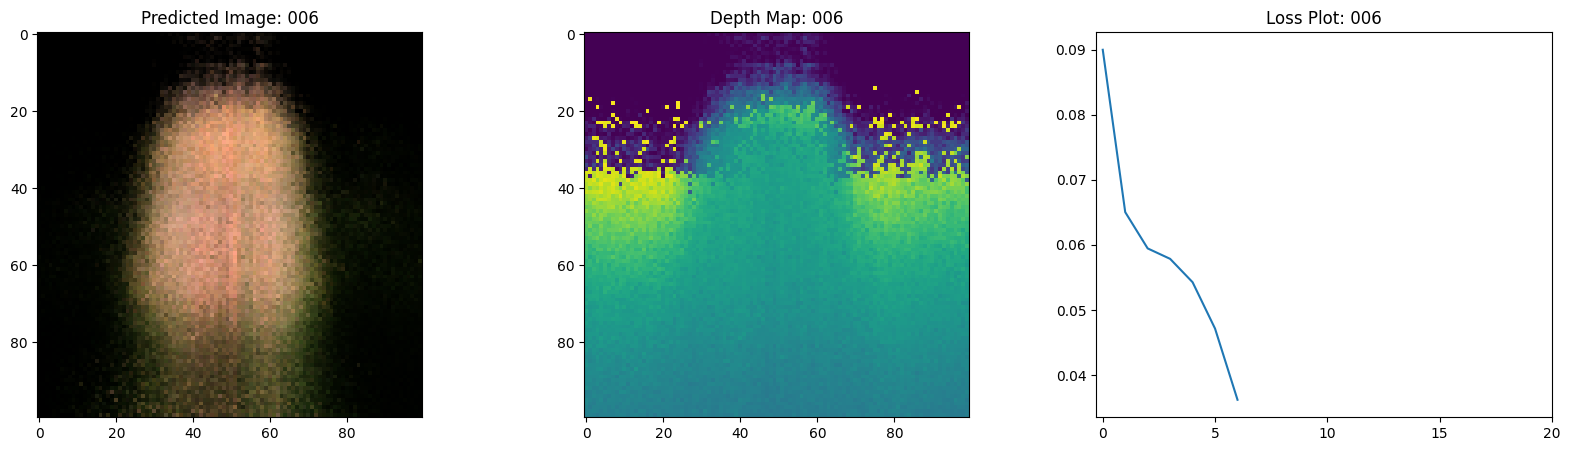

16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.0378 - psnr: 14.5745 - val_loss: 0.0329 - val_psnr: 15.0504
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


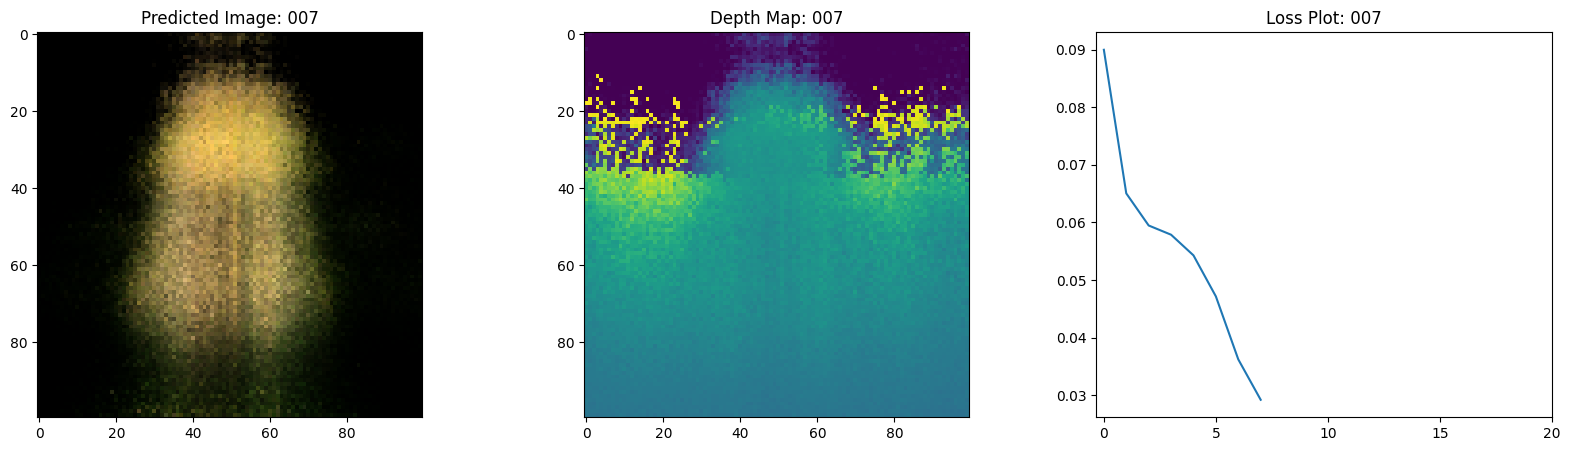

16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0294 - psnr: 15.5370 - val_loss: 0.0281 - val_psnr: 15.6495
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


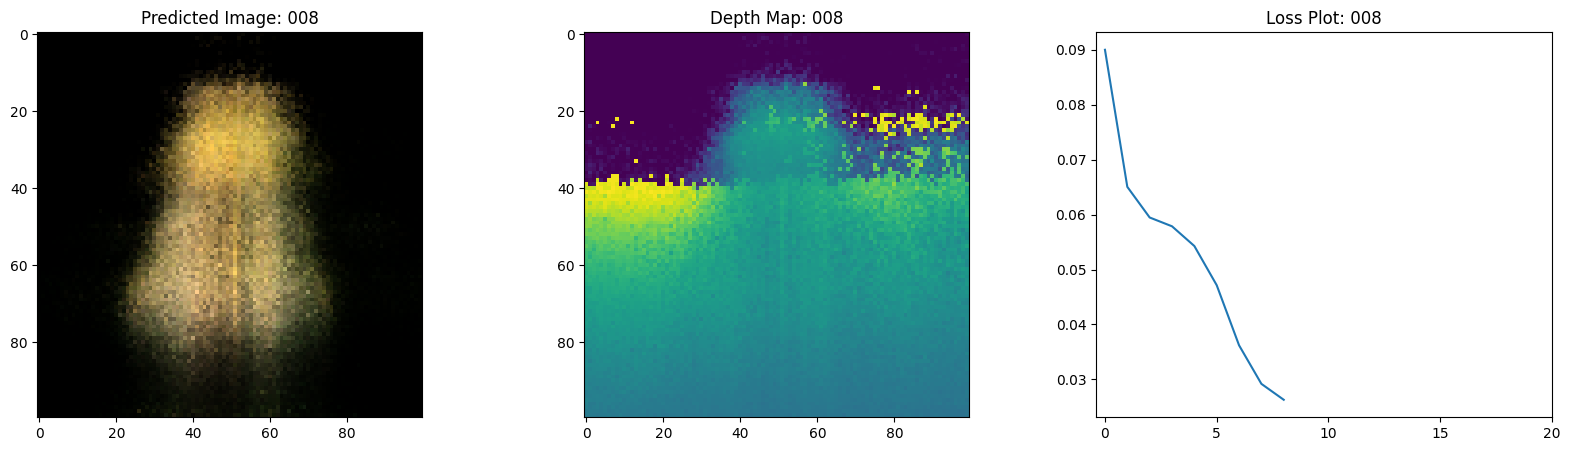

16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.0273 - psnr: 15.8259 - val_loss: 0.0250 - val_psnr: 16.1826
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


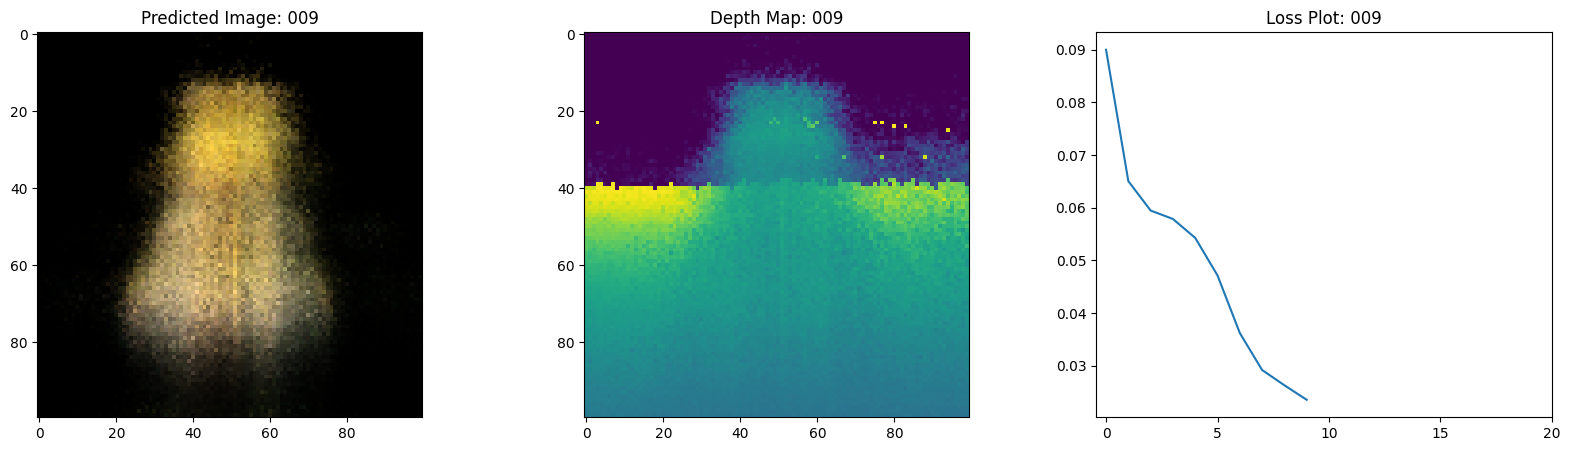

16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 0.0239 - psnr: 16.4107 - val_loss: 0.0228 - val_psnr: 16.5452
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


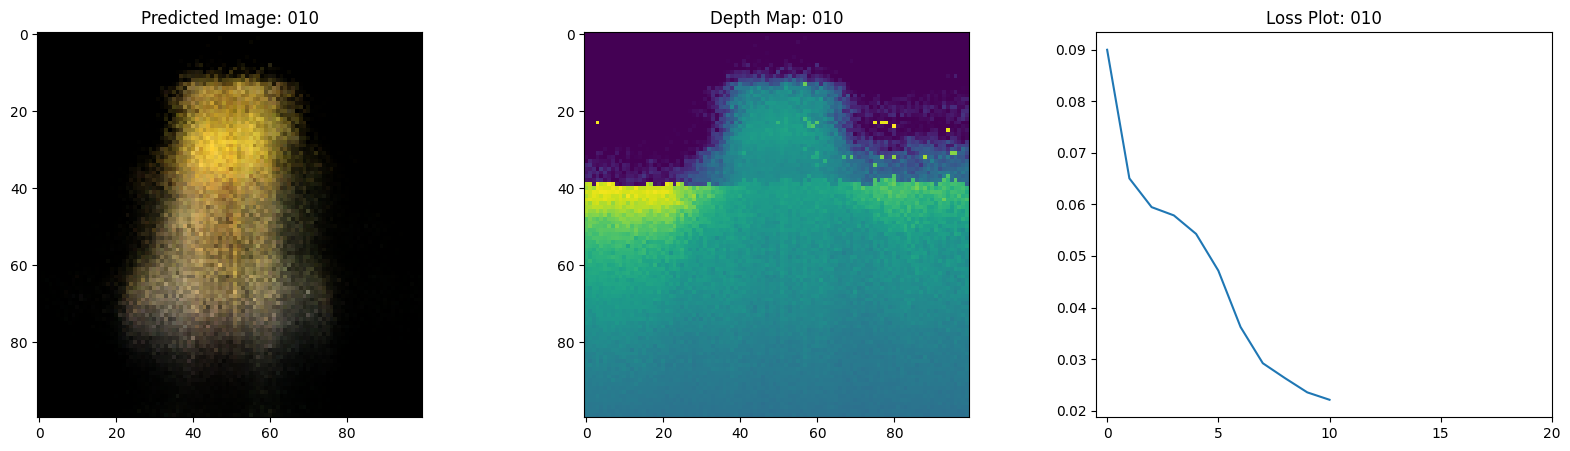

16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 0.0228 - psnr: 16.5770 - val_loss: 0.0205 - val_psnr: 17.0019
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


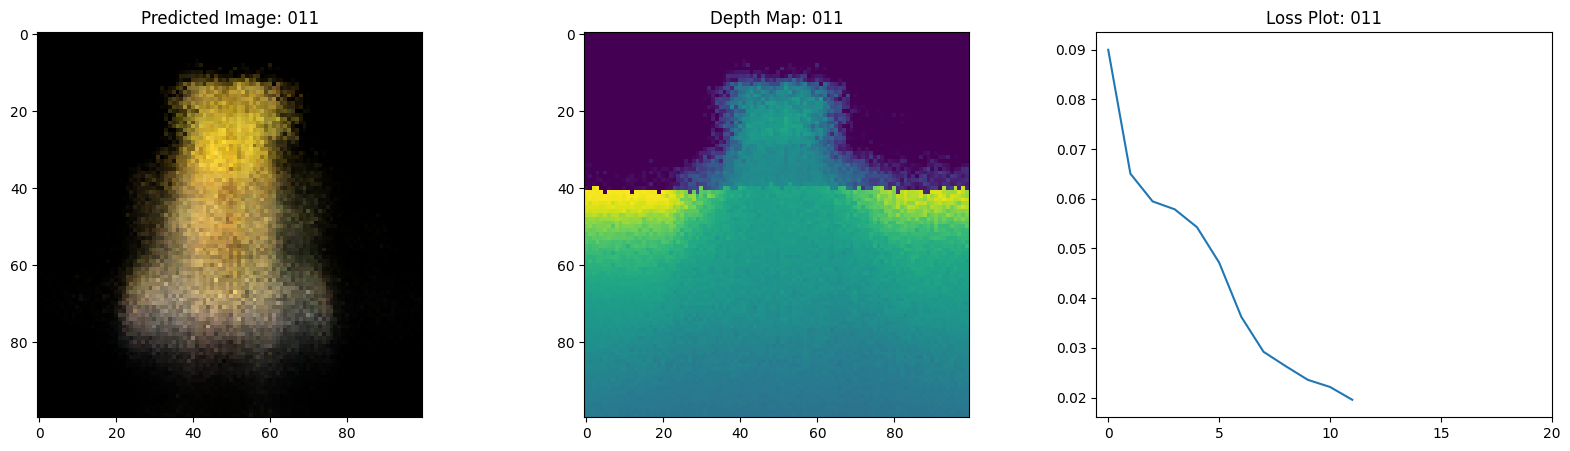

16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.0201 - psnr: 17.1194 - val_loss: 0.0181 - val_psnr: 17.5107
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


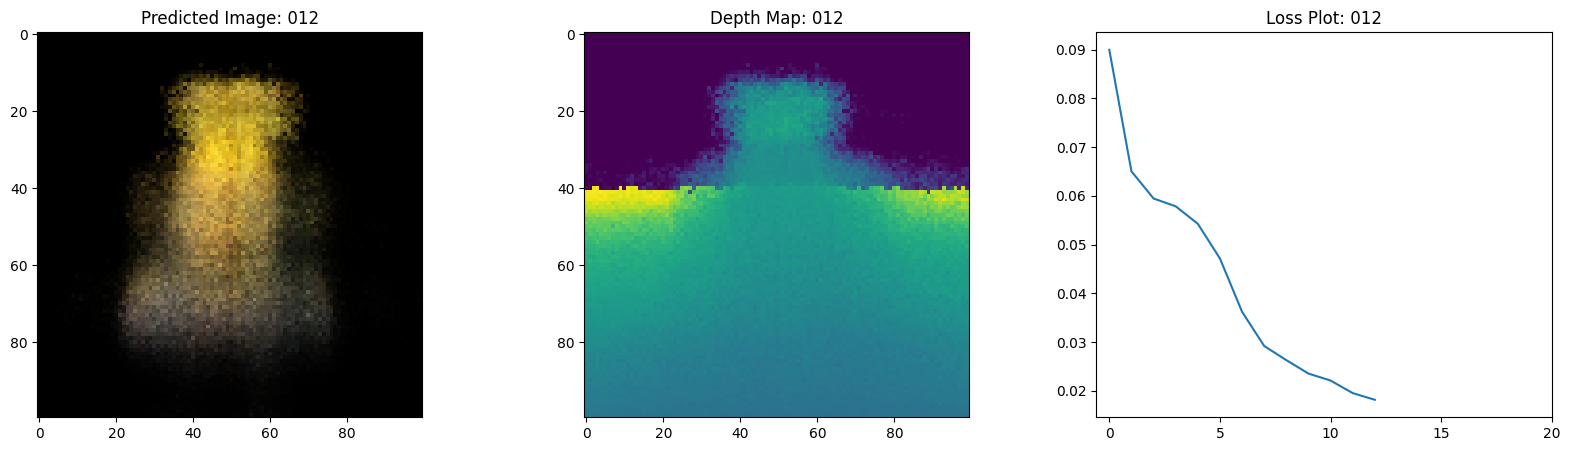

16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - loss: 0.0185 - psnr: 17.4554 - val_loss: 0.0175 - val_psnr: 17.6478
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


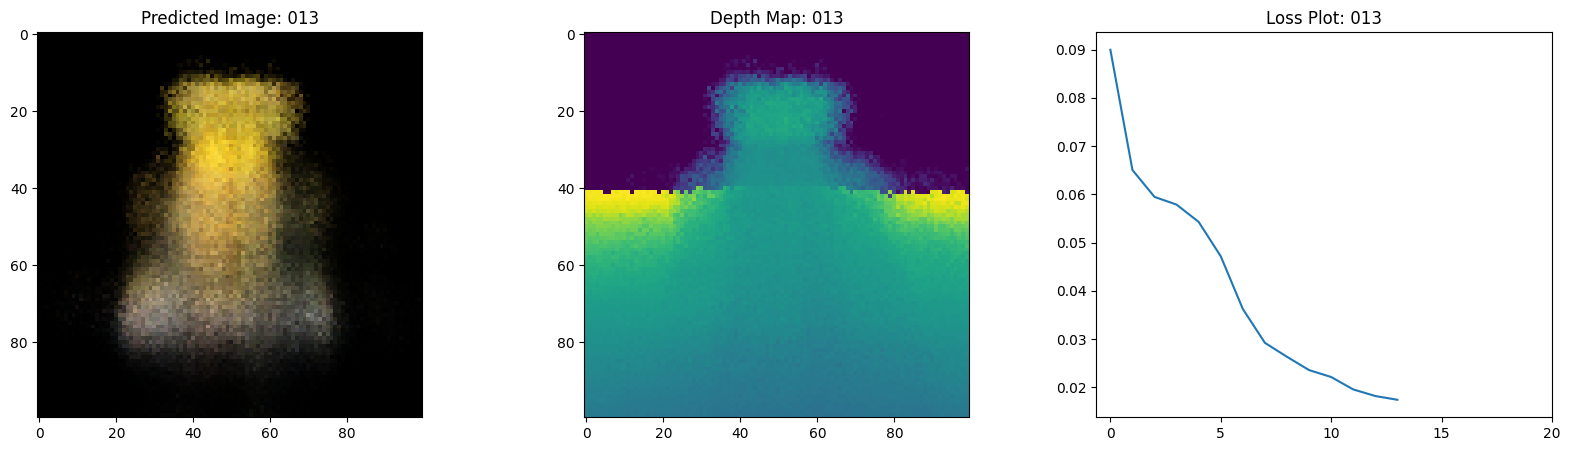

16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0176 - psnr: 17.6724 - val_loss: 0.0177 - val_psnr: 17.5477
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


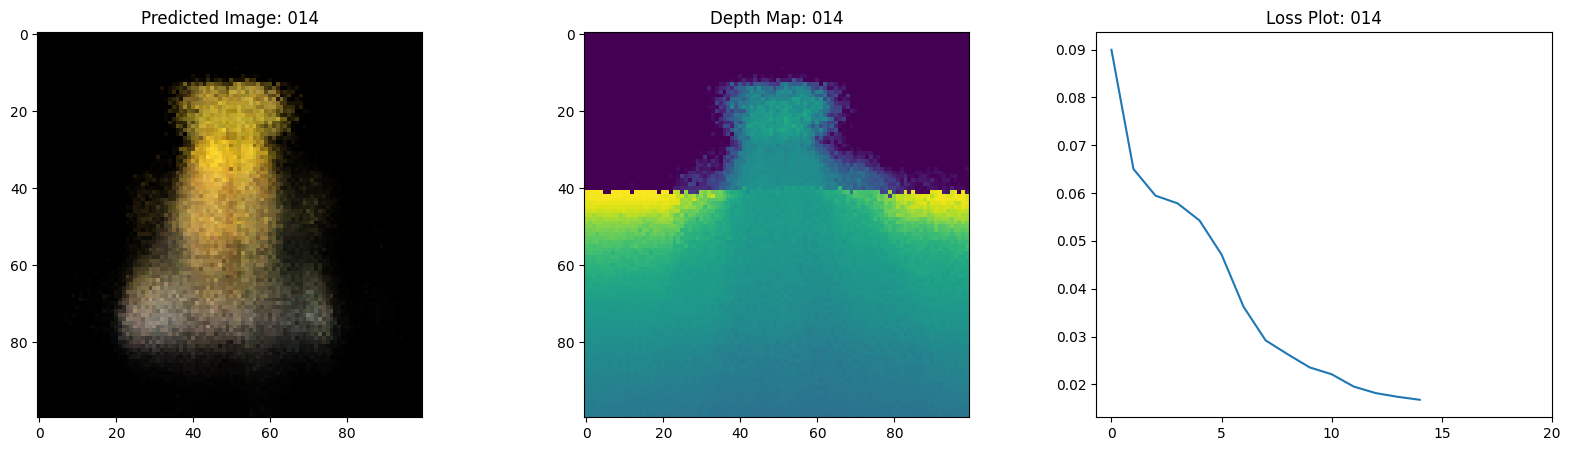

16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 0.0175 - psnr: 17.6916 - val_loss: 0.0165 - val_psnr: 17.9297
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


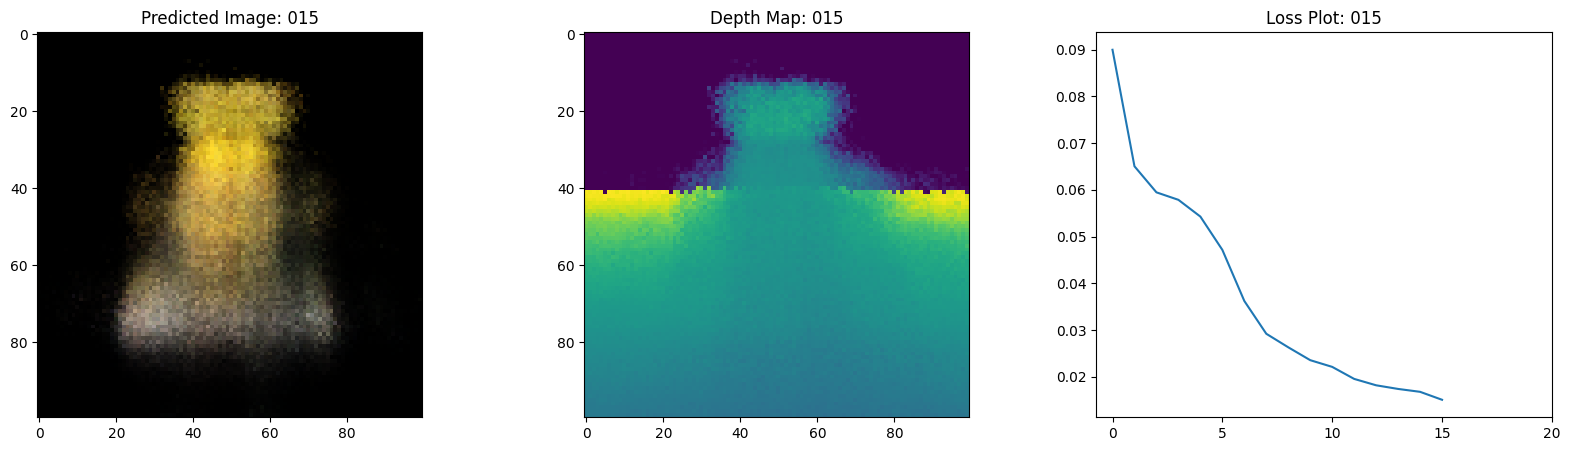

16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0150 - psnr: 18.3652 - val_loss: 0.0151 - val_psnr: 18.2814
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


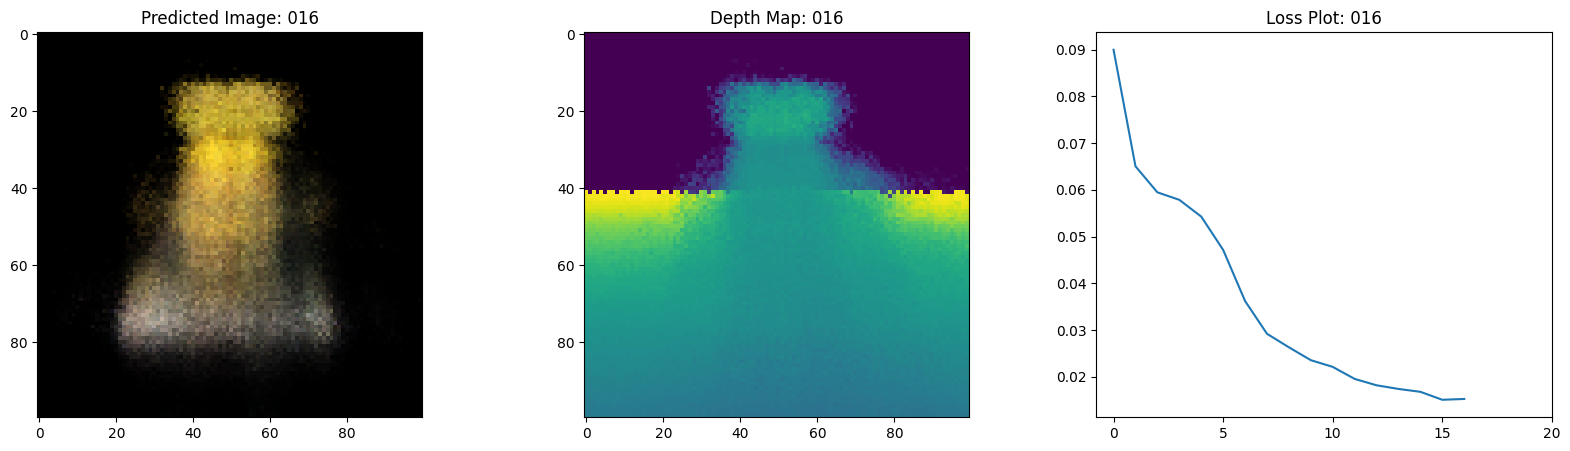

16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0153 - psnr: 18.2495 - val_loss: 0.0146 - val_psnr: 18.4141
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


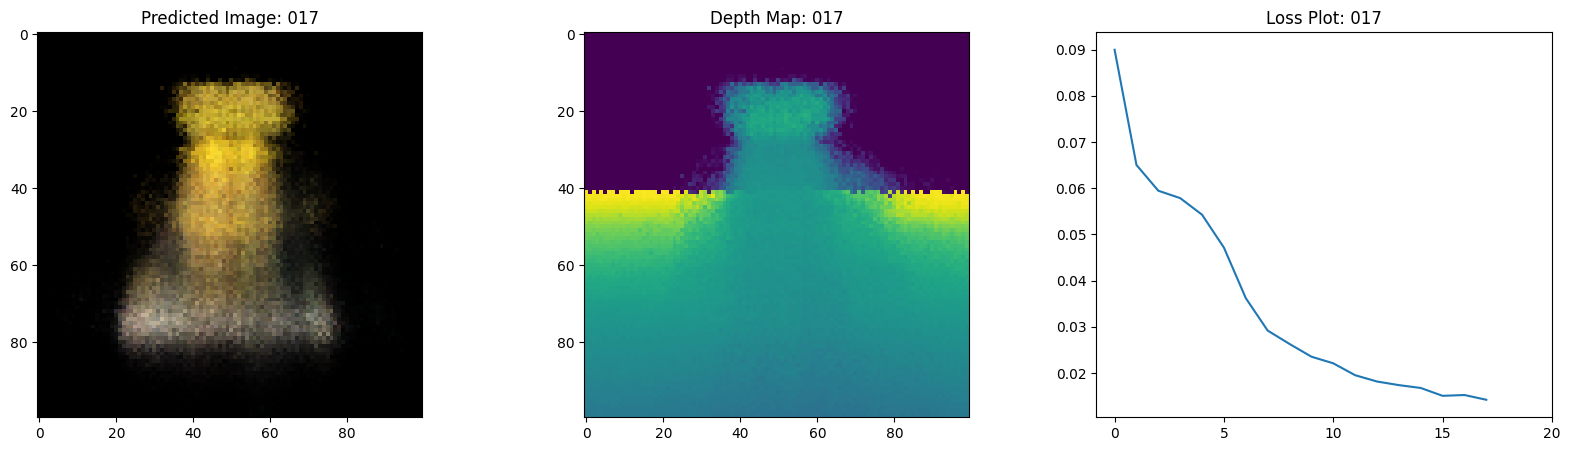

16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0146 - psnr: 18.4847 - val_loss: 0.0134 - val_psnr: 18.8084
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


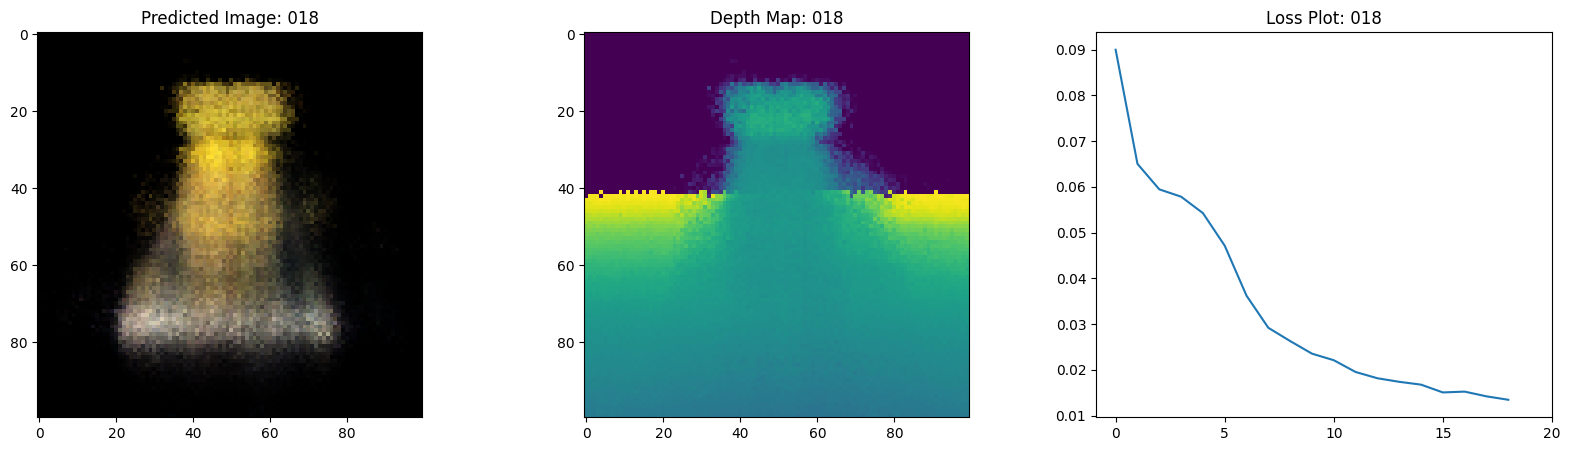

16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - loss: 0.0133 - psnr: 18.8897 - val_loss: 0.0138 - val_psnr: 18.6509
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


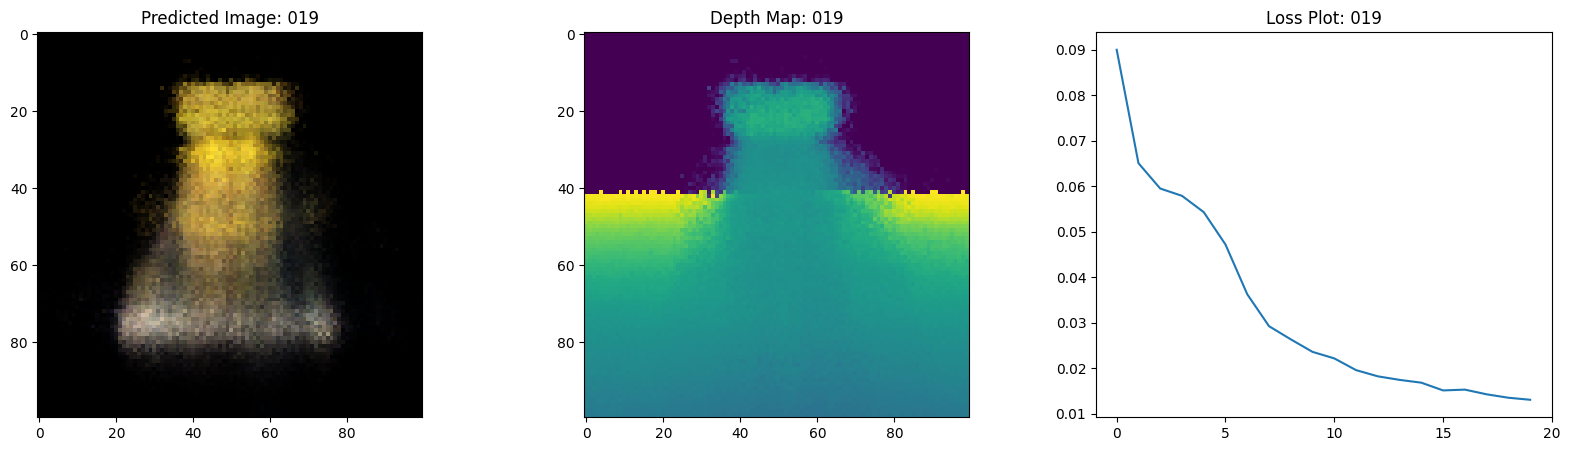

16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 0.0131 - psnr: 18.9543 - val_loss: 0.0129 - val_psnr: 18.9584


In [18]:
model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor()],
)

In [19]:
def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)


create_gif("images/*.png", "training.gif")

100%|██████████| 20/20 [00:00<00:00, 59.59it/s]


In [20]:
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=nerf_model,
    rays_flat=test_rays_flat,
    t_vals=test_t_vals,
    rand=True,
    train=False,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


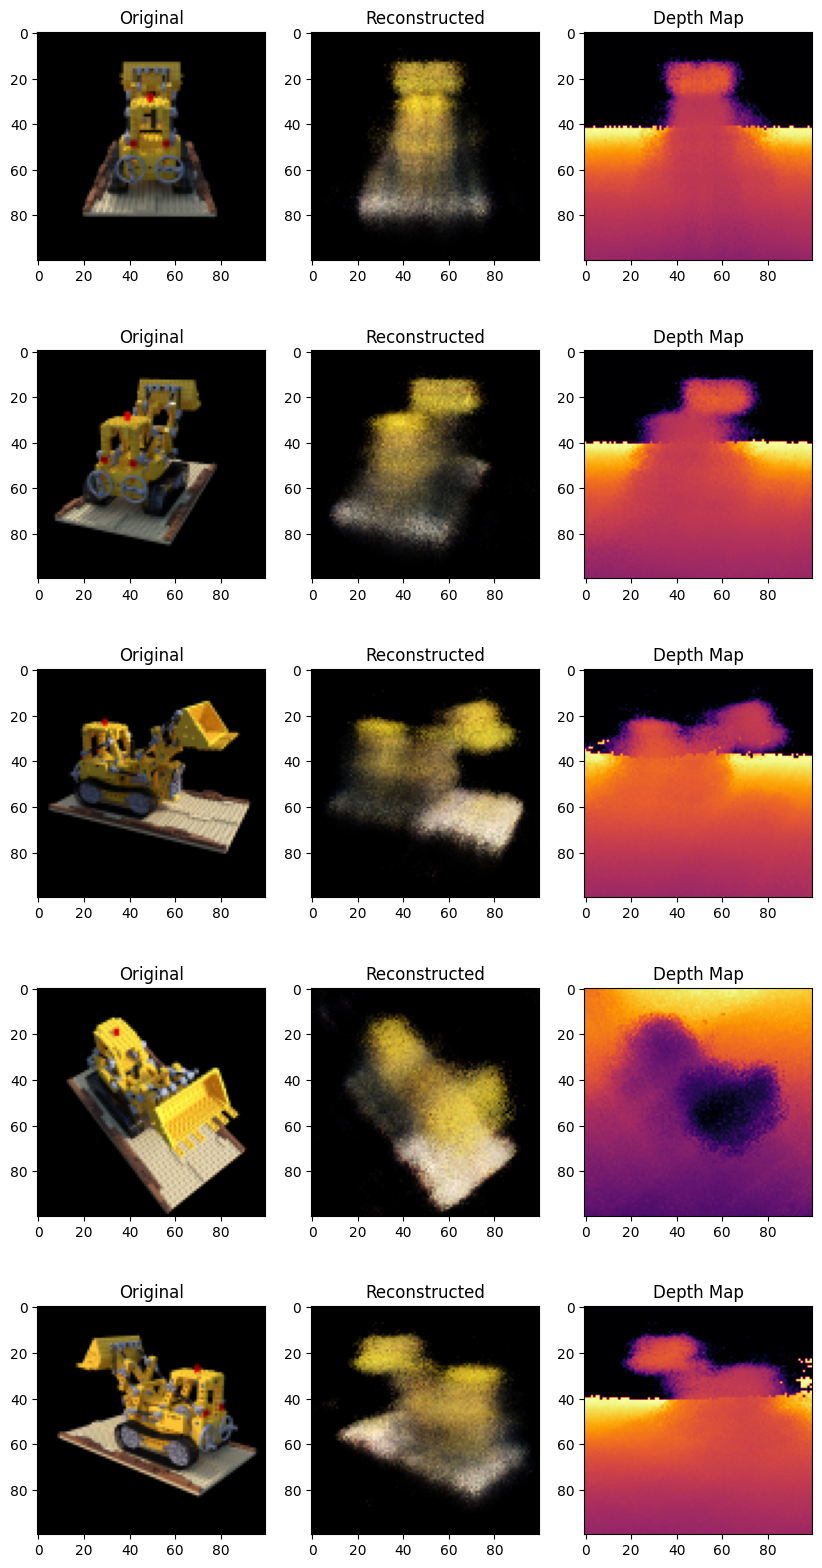

In [21]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for ax, ori_img, recons_img, depth_map in zip(
    axes, test_imgs, test_recons_images, depth_maps
):
    ax[0].imshow(keras.utils.array_to_img(ori_img))
    ax[0].set_title("Original")

    ax[1].imshow(keras.utils.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")

    ax[2].imshow(keras.utils.array_to_img(depth_map[..., None]), cmap="inferno")
    ax[2].set_title("Depth Map")

In [22]:
def get_translation_t(t):
    """Get the translation matrix for movement in t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)

In [23]:
def get_rotation_phi(phi):
    """Get the rotation matrix for movement in phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)

In [24]:
def get_rotation_theta(theta):
    """Get the rotation matrix for movement in theta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)

In [25]:
def pose_spherical(theta, phi, t):
    """
    Get the camera to world matrix for the corresponding theta, phi
    and t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w

In [26]:
rgb_frames = []
batch_flat = []
batch_t = []

In [27]:
for index, theta in tqdm(enumerate(np.linspace(0.0, 360.0, 120, endpoint=False))):
    # Get the camera to world matrix.
    c2w = pose_spherical(theta, -30.0, 4.0)

    #
    ray_oris, ray_dirs = get_rays(H, W, focal, c2w)
    rays_flat, t_vals = render_flat_rays(
        ray_oris, ray_dirs, near=2.0, far=6.0, num_samples=NUM_SAMPLES, rand=False
    )

    if index % BATCH_SIZE == 0 and index > 0:
        batched_flat = tf.stack(batch_flat, axis=0)
        batch_flat = [rays_flat]

        batched_t = tf.stack(batch_t, axis=0)
        batch_t = [t_vals]

        rgb, _ = render_rgb_depth(
            nerf_model, batched_flat, batched_t, rand=False, train=False
        )

        temp_rgb = [np.clip(255 * img, 0.0, 255.0).astype(np.uint8) for img in rgb]

        rgb_frames = rgb_frames + temp_rgb
    else:
        batch_flat.append(rays_flat)
        batch_t.append(t_vals)

rgb_video = "rgb_video.mp4"
imageio.mimwrite(rgb_video, rgb_frames, fps=30, quality=7, macro_block_size=None)

5it [00:02,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


7it [00:03,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


11it [00:05,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


16it [00:06,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


21it [00:08,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


26it [00:10,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


31it [00:12,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


40it [00:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


42it [00:16,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


46it [00:17,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


51it [00:19,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


56it [00:20,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


61it [00:21,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


66it [00:23,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


71it [00:24,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


79it [00:26,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


81it [00:28,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


86it [00:29,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


91it [00:31,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


96it [00:32,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


101it [00:33,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


106it [00:35,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


111it [00:37,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


120it [00:39,  3.05it/s]
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
